#### QUESTION: ACME Insurance Inc. offers affordable health insurance to thousands of customer all over the United States. As the lead data scientist at ACME, you're tasked with creating an automated system to estimate the annual medical expenditure for new customers, using information such as their age, sex, BMI, children, smoking habits and region of residence.

#### Estimates from your system will be used to determine the annual insurance premium (amount paid every month) offered to the customer. Due to regulatory requirements, you must be able to explain why your system outputs a certain prediction.

#### You're given a CSV file containing verified historical data, consisting of the aforementioned information and the actual medical charges incurred by over 1300 customers.

>Link to the Dataset:https://www.kaggle.com/datasets/mirichoi0218/insurance

In [2]:
#import the necessary Libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

df=pd.read_csv('insurance.csv')
# df = pd.read_csv('../input/insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


#### The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer.

#### Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

#### Let's check the data type for each column.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


#### Looks like "age", "children", "bmi" (body mass index) and "charges" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values, which saves us a fair bit of work!

In [6]:
 df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#### The ranges of values in the numerical columns seem reasonable too (no negative ages!), so we may not have to do much data cleaning or correction. The "charges" column seems to be significantly skewed however, as the median (50 percentile) is much lower than the maximum value.

## Exploratory Analysis and Visualization

#### Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.

In [9]:
# The following settings will improve the default style and font sizes for our charts.

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Age

#### Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [11]:
#Histogram of Age Distribution

fig = px.histogram(df, 
                   x='age', 
                   marginal='box', 
                   nbins=47, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

#### The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages. The uniform distribution might arise from the fact that there isn't a big variation in the number of people of any given age (between 18 & 64) in the USA.

#### there definitely can be a connection between age and medical charges in an insurance dataset, especially in real-world healthcare scenarios.
#### In general: As age increases, medical charges tend to increase too.

#### Why would medical charges increase with age?
    * Higher risk of health issues
    Older individuals are more likely to have chronic conditions (e.g., diabetes, heart   disease, joint problems). This leads to more doctor visits, tests, treatments, and possibly hospitalization.

    * Preventive vs. Reactive care
    Younger people (like 18–30) often have fewer medical needs, mostly routine checkups. Older adults (40–64) often need more frequent and costly interventions.

    * Insurance plan tiers
    Some insurance plans adjust premiums/coverage based on age, indirectly impacting total charges.

#### Possible Patterns in Data:
    * Linear or Non-linear Trend 
    Medical charges could rise gradually with age — forming a linear relationship.
    Or, charges may rise sharply after a certain age (e.g., 45+) — forming a non-linear (exponential) curve.

In [14]:
fig = px.scatter(df, x='age', y='charges', 
                 title='Age vs Medical Charges',
                 trendline='ols',  # Adds a regression line
                 color='smoker')   # Optional: add smoker as color factor

fig.show()

### We can make the following observations from the above chart:

#### The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.

#### We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

> The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others

> The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".

> The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.

### Body Mass Index(BMI)

#### Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

In [17]:
fig = px.histogram(df, 
                   x='bmi', 
                   marginal='box', 
                   color_discrete_sequence=['red'], 
                   title='Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap=0.1)
fig.show()

#### Let's visualize the relationship between BMI (body mass index) and charges using another scatter plot. Once again, we'll use the values from the "smoker" column to color the points.

In [19]:
fig = px.scatter(df, x='bmi', y='charges', 
                 title='BMI vs Medical Charges',
                 trendline='ols',  # Adds a regression line
                 color='smoker',  # Optional: add smoker as color factor
                 opacity=0.8, 
                 hover_data=['sex'])  

fig.show()

#### It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seem to be significantly higher for smokers with a BMI greater than 30.

### Charges

#### Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

In [22]:
fig = px.histogram(df, 
                   x='charges', 
                   marginal='box', 
                   color='smoker', 
                   color_discrete_sequence=['green', 'grey'], 
                   title='Annual Medical Charges')
fig.update_layout(bargap=0.1)
fig.show()

#### We can make the following observations from the above graph:

   >  For most customers, the annual medical charges are under \$10,000. Only a small  fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
    
   >  There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is \7300,the median for smokers is close to 35,000.

#### distribution of medical charges in connection with other factors like "sex" and "region"

In [25]:


# violin plot to show distribution of charges by region
fig = px.violin(df, 
                x='region', 
                y='charges', 
                box=True, 
                points='all',
                title='Violin Plot: Medical Charges by Region',
                color='region')
fig.show();

In [26]:

fig = px.box(df, x='charges',
              color='sex',color_discrete_sequence=['red','grey'])

fig.show();

### Smoker

#### Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [28]:
df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [29]:
px.histogram(df, x='smoker', title='Smoker',
                   color='sex',color_discrete_sequence=['red','grey'])


#### It appears that 20% of customers have reported that they smoke.

## Correlation

>As you can tell from the analysis, the values in some columns are more closely related to the values in "charges" compared to other columns. E.g. "age" and "charges" seem to grow together, whereas "bmi" and "charges" don't.

>This relationship is often expressed numerically using a measure called the correlation coefficient, which can be computed using the .corr method of a Pandas series.

#### We can measure correlation between two coulm using this function

In [32]:
df.charges.corr(df.age)

0.2990081933306476

In [33]:
df.charges.corr(df.bmi)

0.19834096883362884

##### We can see there is definatly a higher correlation between age and charges than there is between chanrge and bmi

#### To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [36]:
# Create a dictionary to map 'yes'/'no' values to 1/0 for numerical analysis
smoker_values={'yes':1,'no':0}
# Convert the categorical 'smoker' column to numeric values using the mapping
smoker_numeric=df.smoker.map(smoker_values)
# Calculate the correlation coefficient between insurance charges and smoking status
df.charges.corr(smoker_numeric)

0.7872514304984767

#### Here's how correlation coefficients can be interpreted (source):

#### Strength: The greater the absolute value of the correlation coefficient, the stronger the relationship.

>The extreme values of -1 and 1 indicate a perfectly linear relationship where a change in one variable is accompanied by a perfectly consistent change in the other. For these relationships, all of the data points fall on a line. In practice, you won’t see either type of perfect relationship.

>A coefficient of zero represents no linear relationship. As one variable increases, there is no tendency in the other variable to either increase or decrease.

>When the value is in-between 0 and +1/-1, there is a relationship, but the points don’t all fall on a line. As r approaches -1 or 1, the strength of the relationship increases and the data points tend to fall closer to a line.

#### Direction: The sign of the correlation coefficient represents the direction of the relationship.

>Positive coefficients indicate that when the value of one variable increases, the value of the other variable also tends to increase. Positive relationships produce an upward slope on a scatterplot.

>Negative coefficients represent cases when the value of one variable increases, the value of the other variable tends to decrease. Negative relationships produce a downward slope.

<img src="correlation_rel_express.png">

#### The correlation coefficient has the following formula:

<img src="correlation_coefficient_formula.png">

    Pandas dataframes also provide a .corr method to compute the correlation coefficients between all pairs of numeric columns.

In [41]:
numeric_df = df.select_dtypes(include='number')
correlation = numeric_df.corr()
correlation

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


>we can see age has 0.29 correlation with charges

>bmi has 0.19 correlation with charges

>children has 0.06 correlation with charges

>charges has 1.0 correlation with itself (Perfect positive correlation)


#### The result of .corr is called a correlation matrix and is often visualized using a heatmap.

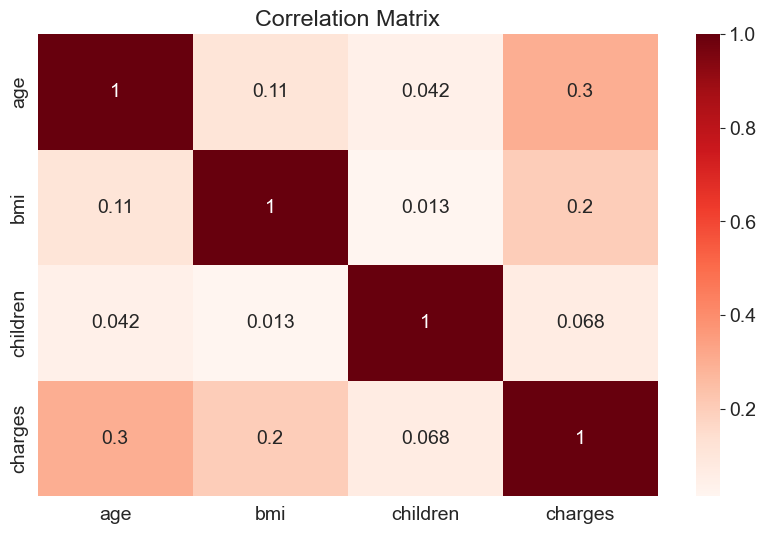

In [44]:
sns.heatmap(numeric_df.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix');

>Correlation vs causation fallacy: Note that a high correlation cannot be used to interpret a cause-effect relationship between features. Two features X and Y can be correlated if X causes Y or if Y causes X, or if both are caused independently by some other factor Z, and the correlation will no longer hold true if one of the cause-effect relationships is broken. It's also possible that X are Y simply appear to be correlated because the sample is too small.

>While this may seem obvious, computers can't differentiate between correlation and causation, and decisions based on automated system can often have major consequences on society, so it's important to study why automated systems lead to a given result. Determining cause-effect relationships requires human insight.

# Linear Regression using a Single Feature

    We now know that the "smoker" and "age" columns have the strongest correlation with "charges". Let's try to find a way of estimating the value of "charges" using the value of "age" for non-smokers. First, let's create a data frame containing just the data for non-smokers..

In [47]:
non_smoker_df=df[df['smoker']=='no']
non_smoker_df

,age,sex,bmi,children,smoker,region,charges
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
...,...,...,...,...,...,...,...
1332,52,female,44.700,3,no,southwest,11411.68500
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350


    Next, let's visualize the relationship between "age" and "charges"

In [49]:
fig = px.scatter(non_smoker_df, x='age', y='charges', 
                 title='Age vs Medical Charges for non-smoker',
                 trendline='ols')  # Adds a regression line
                

fig.show()

    Apart from a few exceptions, the points seem to form a line. We'll try and "fit" a line using this points, and use the line to predict charges for a given age. A line on the X&Y coordinates has the following formula:
  #### y=wx+b
    The line is characterized two numbers: w (called "slope") and b (called "intercept").

### Model
    In the above case, the x axis shows "age" and the y axis shows "charges". Thus, we're assume the following relationship between the two:
  #### charges=w×age+b

    We'll try determine w and b for the line that best fits the data.

>This technique is called linear regression, and we call the above equation a linear regression model, because it models the relationship between "age" and "charges" as a straight line.

>The numbers w and b are called the parameters or weights of the model.

>The values in the "age" column of the dataset are called the inputs to the model and the values in the charges column are called "targets".

    Let define a helper function estimate_charges, to compute charges,given age,w and b



In [51]:
def estimate_charges(age,w,b):
    return w*age+b

    The estimate_charges function is our very first model.
    Let's guess the values for w (weights ) and b (bias) and use them to estimate the value for charges.

> “Weight tells how fast the output changes when input changes.”

> “Bias is like lifting the whole line up or down.”

#### to understand weight, bias, and linear regression. Let’s make it super real and simple with our insurance data! 🧾💉💰

    What You’re Doing:
    You have:

    age ➡️ how old the person is
    charges ➡️ how much they paid (or were charged) for insurance

    You want to predict insurance charges using someone’s age — and that’s where linear regression comes in!

>📈 The Formula:charges=(weight×age)+bias

    Don’t worry! Let’s break this down like a story.

    🧸 Imagine This: You're drawing a line to guess charges based on age. This line goes up because usually, older people = more charges.

    🤔 So what do weight and bias do here?
>🔹 Weight (W):
This decides how strongly age affects charges
→ Bigger weight = "If age increases, charges increase A LOT"
→ Smaller weight = "If age increases, charges increase just a little"

>🔹 Bias (b):
This tells where the line starts
→ Even at age 0, a person might still have some base charge — bias adds that starting value

    ✅ Real-world Example:
    Let’s say your model finds: charges=250×age+3000
    This means: For every 1 year older → charges go up by ₹250
    Even a newborn (age = 0) has a base charge of ₹3000 (maybe for registration or minimum policy)

    🔧 scikit-learn will automatically find the best weight & bias
    You don’t choose them manually. It looks at all your data and picks values that make the line fit best (so the prediction is close to real charges).



In [54]:
w=50
b=100

In [55]:
estimate_charges(30,w,b)

1600

In [56]:
ages=non_smoker_df.age
estimated_charges=estimate_charges(ages,w,b)
estimated_charges

1       1000
2       1500
3       1750
4       1700
5       1650
        ... 
1332    2700
1333    2600
1334    1000
1335    1000
1336    1150
Name: age, Length: 1064, dtype: int64

In [57]:
non_smoker_df.charges

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1064, dtype: float64

    we can see we are too far from the actual charges
    we can plot the estimated charges using a line graph.

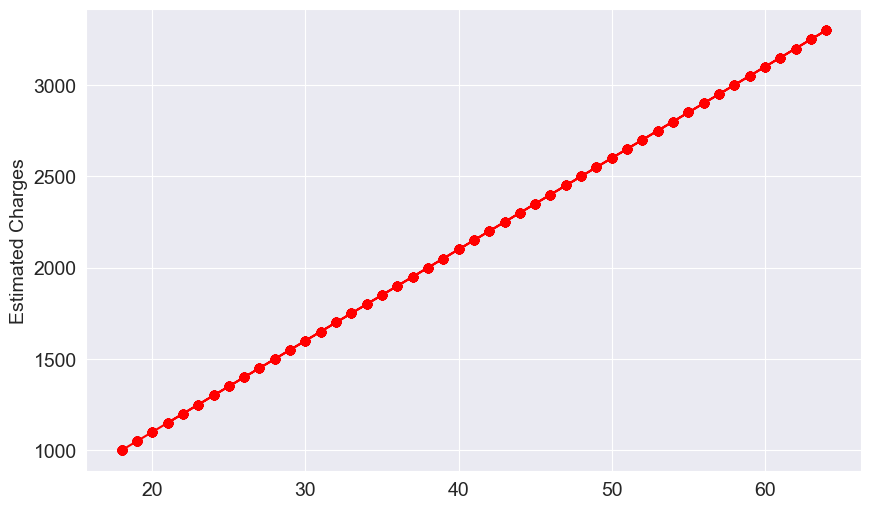

In [59]:
plt.plot(ages,estimated_charges,'r-o')
plt.ylabel('Age')
plt.ylabel('Estimated Charges')
plt.show()

    As expected, the points lie on a straight line.

    We can overlay this line on the actual data, so see how well our model fits the data.

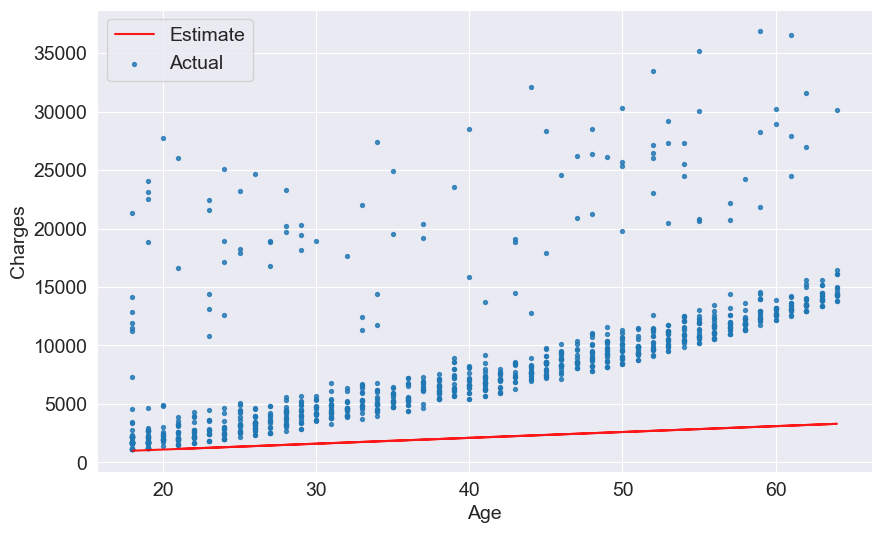

In [61]:
target = non_smoker_df.charges

plt.plot(ages, estimated_charges, 'r', alpha=0.9);
plt.scatter(ages, target, s=8,alpha=0.8);
plt.xlabel('Age');
plt.ylabel('Charges')
plt.legend(['Estimate', 'Actual']);
plt.show()

    Clearly, the our estimates are quite poor and the line does not "fit" the data. However, we can try different values of w and b to move the line around. Let's define a helper function try_parameters which takes w and b as inputs and creates the above plot.

In [63]:
def try_parameter(w,b):
    ages=non_smoker_df.age
    target=non_smoker_df.charges

    estimated_charges=estimate_charges(ages,w,b)
    plt.plot(ages, estimated_charges, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Estimate', 'Actual']);
    plt.show()

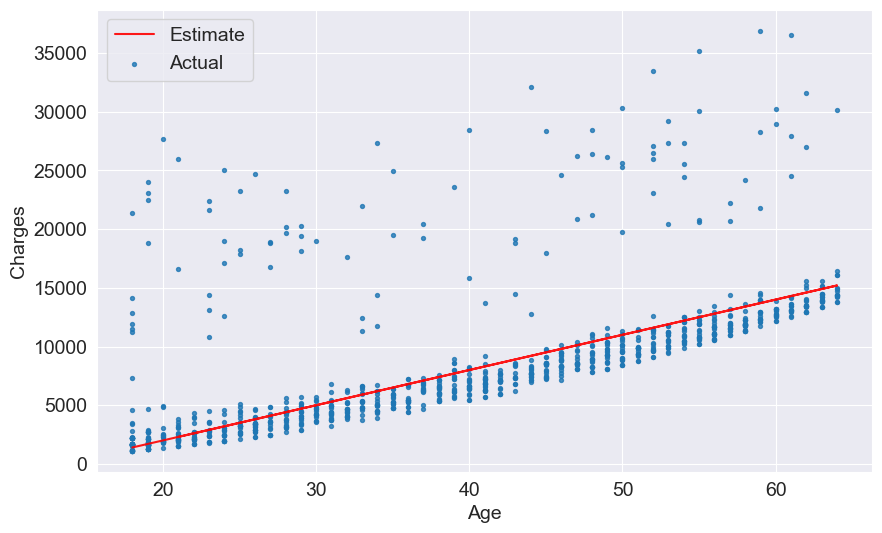

In [64]:
#we can try various values of w and b to find a line that best fits the data.
try_parameter(300,-4000) 

    As we change the values, of w and b manually, trying to move the line visually closer to the points, we are learning the approximate relationship between "age" and "charges".

    Wouldn't it be nice if a computer could try several different values of w and b and learn the relationship between "age" and "charges"? To do this, we need to solve a couple of problems:

>We need a way to measure numerically how well the line fits the points.

>Once the "measure of fit" has been computed, we need a way to modify w and b to improve the the fit.

    If we can solve the above problems, it should be possible for a computer to determine w and b for the best fit line, starting from a random guess.

## Loss/Cost Function
    We can compare our model's predictions with the actual targets using the following method:

>Calculate the difference between the targets and predictions (the differenced is called the "residual")

>Square all elements of the difference matrix to remove negative values.

>Calculate the average of the elements in the resulting matrix.

>Take the square root of the result

    The result is a single number, known as the root mean squared error (RMSE). The above description can be stated mathematically as follows:



<img src="RMSE.png">


    Geometrically, the residuals can be visualized as follows:
 <img src="residuals.png">


In [68]:
target #non_smoker.charges

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1064, dtype: float64

In [69]:
predictions=estimated_charges #this on for the w=50 and b=100 we calculate initially
predictions

1       1000
2       1500
3       1750
4       1700
5       1650
        ... 
1332    2700
1333    2600
1334    1000
1335    1000
1336    1150
Name: age, Length: 1064, dtype: int64

    lets defined a function to computethe RMSE

In [71]:
def rmse(targets,predictions):
    return np.sqrt(np.mean(np.square(targets-predictions)))

    Let's compute the RMSE for our model with a sample set of weights

In [73]:
rmse(target,predictions)

8461.949562575493

    Here's how we can interpret the above number: On average, each element in the prediction differs from the actual target by \$8461.

    The result is called the loss because it indicates how bad the model is at predicting the target variables. It represents information loss in the model: the lower the loss, the better the model.

    Let's modify the try_parameters functions to also display the loss.

In [75]:
def try_parameter(w,b):
    ages=non_smoker_df.age
    target=non_smoker_df.charges
    predictions=estimate_charges(ages,w,b)

    plt.plot(ages, predictions, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Charges')
    plt.legend(['Prediction', 'Actual']);
    plt.show()

    loss=rmse(target,predictions)
    print("RMSE Loss: ",loss)

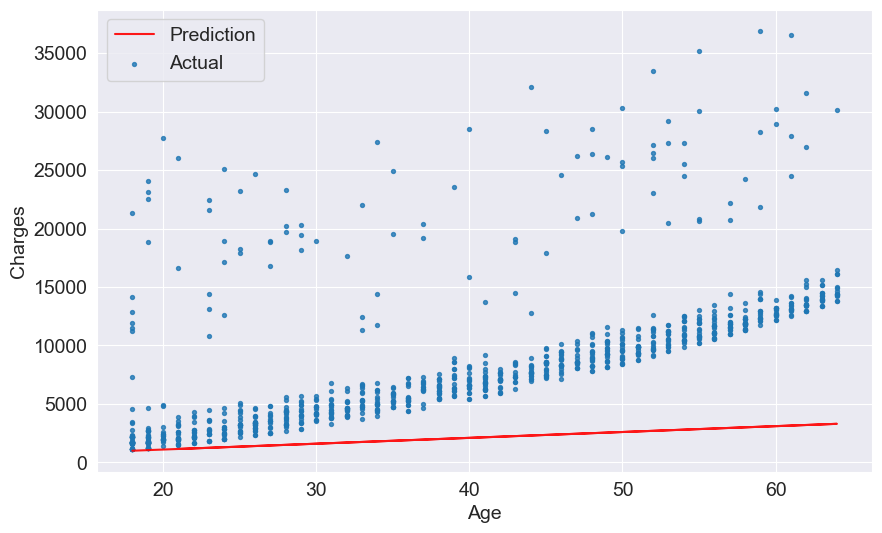

RMSE Loss:  8461.949562575493


In [76]:
try_parameter(50,100)

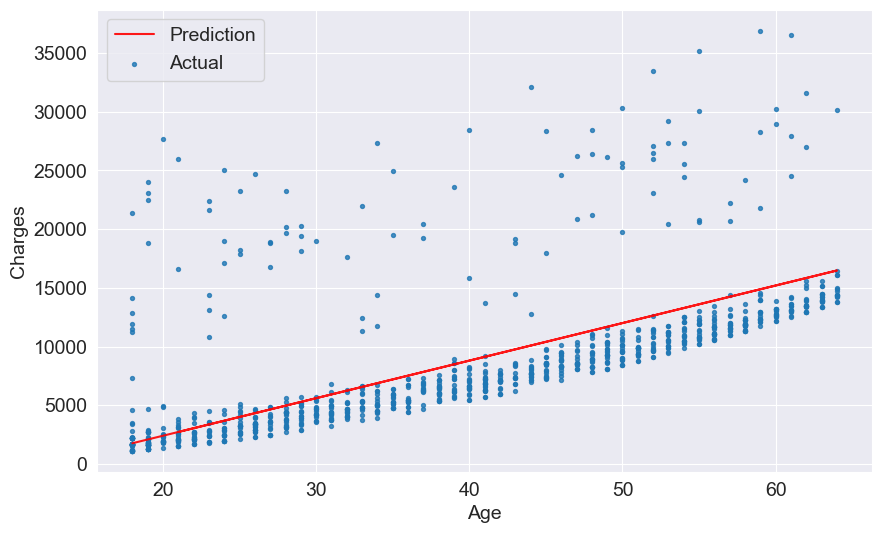

RMSE Loss:  4724.292411612061


In [77]:
try_parameter(320,-4000)

## Optimizer
    Next, we need a strategy to modify weights w and b to reduce the loss and improve the "fit" of the line to the data.

>Ordinary Least Squares: https://www.youtube.com/watch?v=szXbuO3bVRk (better for smaller datasets)

>Stochastic gradient descent: https://www.youtube.com/watch?v=sDv4f4s2SB8 (better for larger datasets)

        Both of these have the same objective: to minimize the loss, however, while ordinary least squares directly computes the best values for w and b using matrix operations, while gradient descent uses a iterative approach, starting with a random values of w and b and slowly improving them using derivatives.

# Linear Regression using Scikit-learn
    In practice, you'll never need to implement either of the above methods yourself. You can use a library like scikit-learn to do this for you.
    
    Let's use the LinearRegression class from scikit-learn to find the best fit line for "age" vs. "charges" using the ordinary least squares optimization technique.

In [80]:
from sklearn.linear_model import LinearRegression

    First, we create a new model object.

In [82]:
model=LinearRegression()  

>When we said model=LinearRegression() we alreday mentioned to scikit-leaarn that we want to assume a linear a linear relationship between our inputs and targets. That means we want our targets which is charges to be w*age+b

    Next, we can use the fit method of the model to find the best fit line for the inputs and targets.

In [85]:
help(model.fit)

Help on method fit in module sklearn.linear_model._base:

fit(X, y, sample_weight=None) method of sklearn.linear_model._base.LinearRegression instance
    Fit linear model.

    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training data.

    y : array-like of shape (n_samples,) or (n_samples, n_targets)
        Target values. Will be cast to X's dtype if necessary.

    sample_weight : array-like of shape (n_samples,), default=None
        Individual weights for each sample.

        .. versionadded:: 0.17
           parameter *sample_weight* support to LinearRegression.

    Returns
    -------
    self : object
        Fitted Estimator.



    Not that the input X must be a 2-d array, so we'll need to pass a dataframe, instead of a single column.

In [87]:
#lets create input and targets
inputs=non_smoker_df[['age']]
targets=non_smoker_df.charges

print('inputs.shape :', inputs.shape)
print('targes.shape :', targets.shape)

inputs.shape : (1064, 1)
targes.shape : (1064,)


In [88]:
inputs #2D array or dataframe

,age
1,18
2,28
3,33
4,32
5,31
...,...
1332,52
1333,50
1334,18
1335,18


    Let's fit the model to the data.

In [90]:
model.fit(inputs,targets)

LinearRegression()

>here we are telling the scikit learn that these are the inputs(ages) and target(charges), and to calculate the loss so may be first guess some random w and b, get the prediction, compare the prediction with the targets, See how how the prediction are and then use a  Ordinary Least Squares algorithm or use some other optimization strategies to improve the values of w and b. And keep improving until we get the best results. All the things are coded inside the model.

>LinearRegression class uses the optimization technique Ordinary Least Squares algorithm

    We can now make predictions using the model. Let's try predicting the charges for the ages 23, 37 and 61



In [93]:
#lets predict for some ages
model.predict(np.array([[23],[37],[61]]))

C:\Users\amrit\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([ 4055.30443855,  7796.78921819, 14210.76312614])

    Do these values seem reasonable? Compare them with the scatter plot above.

    Let compute the predictions for the entire set of inputs

In [95]:
predictions=model.predict(inputs)
predictions

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])

In [96]:
targets

1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
5        3756.62160
           ...     
1332    11411.68500
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
Name: charges, Length: 1064, dtype: float64

    Let's compute the RMSE loss to evaluate the model.

In [98]:
rmse(targets,predictions)

4662.505766636395

    Seems like our prediction is off by $4000 on average, which is not too bad considering the fact that there are several outliers.

    The parameters of the model are stored in the coef_ and intercept_ properties.

In [100]:
# w
model.coef_

array([267.24891283])

In [101]:
# b
model.intercept_

-2091.4205565650827

    Are these parameters close to your best guesses?

    Let's visualize the line created by the above parameters.

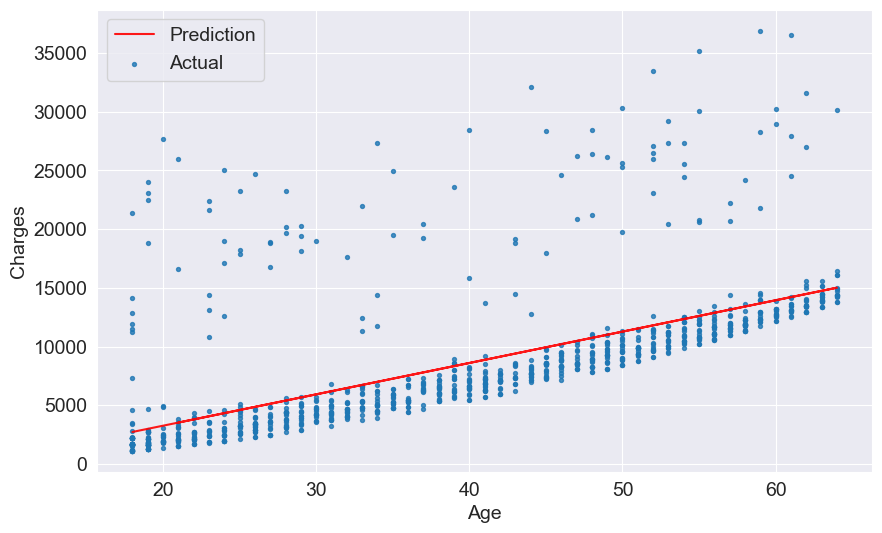

RMSE Loss:  4662.505766636395


In [103]:
try_parameter(model.coef_,model.intercept_)

    Indeed the line is quite close to the points. It is slightly above the cluster of points, because it's also trying to account for the outliers.

### Using the SGDRegressor class from scikit-learn to train a model using the stochastic gradient descent technique. Make predictions and compute the loss

In [106]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

In [107]:
# 1. Input and target
inputs = non_smoker_df[['age']]
targets = non_smoker_df['charges']

# 2. Standardize input (very important for SGD)
scaler = StandardScaler()
inputs_scaled = scaler.fit_transform(inputs)

# 3. Train the model
sgd_model = SGDRegressor(max_iter=1000, random_state=42)
sgd_model.fit(inputs_scaled, targets)

# 4. Predict
predictions = sgd_model.predict(inputs_scaled)

# 5. RMSE (your custom function)
rmse(targets, predictions)

4662.578503411452

> Standardizing the input feature is crucial when using SGD (Stochastic Gradient Descent)
 because it helps the algorithm converge faster and more reliably.
 Features like 'age' may have values ranging from 18 to 64, and large differences in scale
 can lead to unstable or inefficient updates during training.
 By using StandardScaler(), we transform the 'age' column so that it has a mean of 0
 and a standard deviation of 1. This ensures the model treats the feature on a consistent scale,
 leading to better performance and a lower RMSE.

In [109]:
smoker_df=df[df['smoker']=='yes']
smoker_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
11,62,female,26.290,0,yes,southeast,27808.72510
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
...,...,...,...,...,...,...,...
1313,19,female,34.700,2,yes,southwest,36397.57600
1314,30,female,23.655,3,yes,northwest,18765.87545
1321,62,male,26.695,0,yes,northeast,28101.33305
1323,42,female,40.370,2,yes,southeast,43896.37630


In [110]:
fig = px.scatter(smoker_df, x='age', y='charges', 
                 title='Age vs Medical Charges for non-smoker',
                 trendline='ols')  # Adds a regression line
                

fig.show()

In [111]:
model=LinearRegression()

inputs=smoker_df[['age']]
targets=smoker_df.charges

model.fit(inputs,targets)
predictions=model.predict(inputs)
rmse(targets,predictions)


10711.00334810241

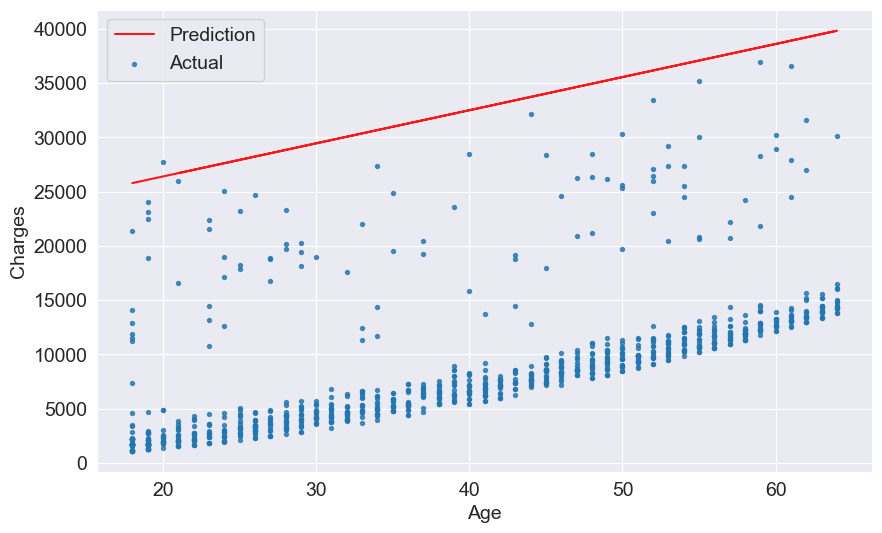

RMSE Loss:  24338.502872599216


In [112]:
try_parameter(model.coef_,model.intercept_)

In [113]:
def gradient_descent(inputs,targets):


# 2. Standardize input (very important for SGD)
    scaler = StandardScaler()
    inputs_scaled = scaler.fit_transform(inputs)

# 3. Train the model
    sgd_model = SGDRegressor(max_iter=1000, random_state=42)
    sgd_model.fit(inputs_scaled, targets)

# 4. Predict
    predictions = sgd_model.predict(inputs_scaled)

# 5. RMSE (your custom function)
    print('RMSE: ',rmse(targets, predictions) )

In [114]:
gradient_descent(inputs,targets)

RMSE:  10711.029450839265


>RMSE for smoker group is higher (~10711) even after using OLS and SGD.
This suggests that age alone is not sufficient to accurately predict charges for smokers,
possibly due to higher variance in charges caused by other factors like BMI, health risks, or lifestyle.
To improve predictions, we may need to include more features or consider non-linear models.

## Model Performance Checklist ✅
    Use this right after building a basic model like OLS or SGD

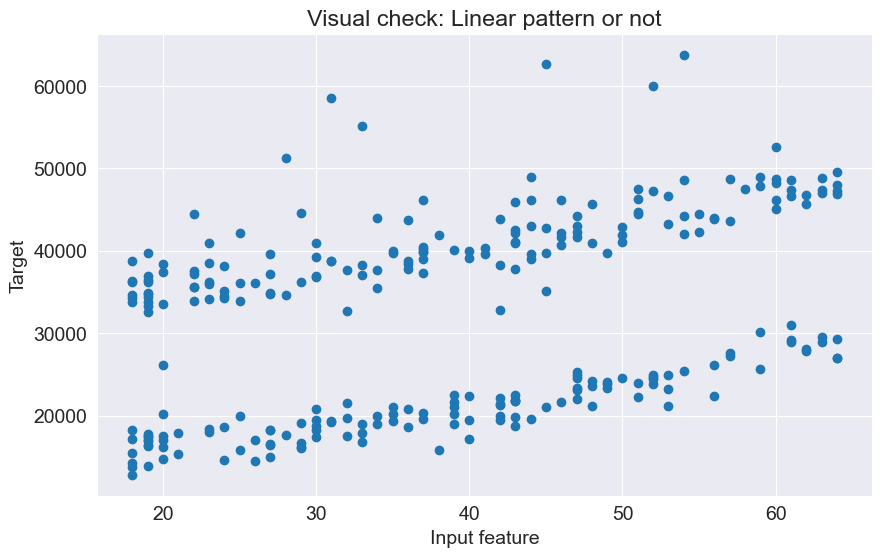

Mean charges: 32050.23183153284
RMSE: 10711.00334810241
R² score: 0.13558924096084068
Weight: [305.23760211]
Bias: 20294.128126915966


In [117]:
# ✅ 1. Scatter plot to check linearity
plt.scatter(inputs, targets)
plt.xlabel('Input feature')
plt.ylabel('Target')
plt.title('Visual check: Linear pattern or not')
plt.show()
# ➤ If the pattern is scattered or curved → linear models may not perform well

# ✅ 2. Compare RMSE with average charges
print("Mean charges:", targets.mean())
print("RMSE:", rmse(targets, predictions))
# ➤ If RMSE is large compared to mean (e.g. >30-40%) → model might be underfitting

# ✅ 3. Check R² score
from sklearn.metrics import r2_score
r2 = r2_score(targets, predictions)
print("R² score:", r2)
# ➤ R² > 0.7 → good, 0.5–0.7 → okay, < 0.3 → try more features or smarter model

# ✅ 4. Check model coefficients (optional but insightful)
print("Weight:", model.coef_)
print("Bias:", model.intercept_)
# ➤ Helps understand model behavior (Is it too flat? Too steep?)

In [118]:
#Let's create a function to evaluate model performace
def model_performance_lr(inputs,target,prediction):
    # ✅ 1. Scatter plot to check linearity
    plt.scatter(inputs, targets)
    plt.xlabel('Input feature')
    plt.ylabel('Target')
    plt.title('Visual check: Linear pattern or not')
    plt.show()
    # ➤ If the pattern is scattered or curved → linear models may not perform well

    # ✅ 2. Compare RMSE with average charges
    print("Mean charges:", targets.mean())
    print("RMSE:", rmse(targets, predictions))
    # ➤ If RMSE is large compared to mean (e.g. >30-40%) → model might be underfitting

    # ✅ 3. Check R² score
    from sklearn.metrics import r2_score
    r2 = r2_score(targets, predictions)
    print("R² score:", r2)
    # ➤ R² > 0.7 → good, 0.5–0.7 → okay, < 0.3 → try more features or smarter model


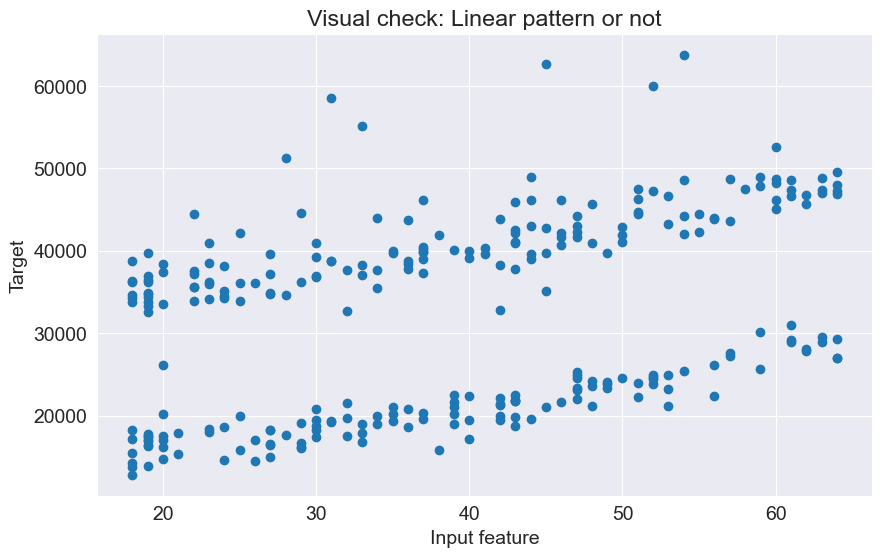

Mean charges: 32050.23183153284
RMSE: 10711.00334810241
R² score: 0.13558924096084068


In [119]:
model_performance_lr(inputs,targets,predictions)

# Machine Learning
    
    Machine learning is simply the process of computing the best parameters to model the relationship between some feature and targets.

    Every machine learning problem has three components:

>1. Model

>2. Cost Function

>3. Optimizer

    We'll look at several examples of each of the above in future tutorials. Here's how the relationship between these three components can be visualized:

 <img src="ML_component.png">
 
    As we've seen above, it takes just a few lines of code to train a machine learning model using scikit-learn.

In [121]:
# Create inputs and targets
inputs, targets = smoker_df[['age']], smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 10711.00334810241


# Linear Regression using Multiple Features

    So far, we've used on the "age" feature to estimate "charges". Adding another feature like "bmi" is fairly straightforward. We simply assume the following relationship:

>charges=w1​×age+w2​×bmi+b

    We need to change just one line of code to include the BMI.

In [123]:
#for smoker
# Create inputs and targets
inputs,targets=smoker_df[['age','bmi']],smoker_df['charges']

# Create and train the model
model=LinearRegression().fit(inputs, targets)

# Generate predictions
predictions=model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 5722.782238884455


    Previously with single feature (age) the loss was 10711 which ws too high, but using two feature age and bmi, It seems like we got a better result i.e 5722. That means adding the BMI does seem to reduce the loss by much

    let's check for non-smoker  with two feature the model will be improving or not

In [125]:
#For non-smoker

# Create inputs and targets
inputs,targets=non_smoker_df[['age','bmi']],non_smoker_df['charges']

# Create and train the model
model=LinearRegression().fit(inputs, targets)

# Generate predictions
predictions=model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4662.3128354612945


    As you can see, adding the BMI doesn't seem to reduce the loss by much, as the BMI has a very weak correlation with charges, especially for non smokers.

In [127]:
non_smoker_df.charges.corr(non_smoker_df.bmi)

0.08403654312833271

In [128]:
fig = px.scatter(non_smoker_df, x='bmi', y='charges', title='BMI vs. Charges')
fig.update_traces(marker_size=5)
fig.show()

    We can also visualize the relationship between all 3 variables "age", "bmi" and "charges" using a 3D scatter plot.


In [130]:
fig = px.scatter_3d(non_smoker_df, x='age', y='bmi', z='charges')
fig.update_traces(marker_size=3, marker_opacity=0.5)
fig.show()

    You can see that it's harder to interpret a 3D scatter plot compared to a 2D scatter plot. As we add more features, it becomes impossible to visualize all feature at once, which is why we use measures like correlation and loss.

    Let's also check the parameters of the model.

In [132]:
model.coef_,model.intercept_

(array([266.87657817,   7.07547666]), -2293.6320906488654)

    Clearly, BMI has a much lower weightage, and you can see why. It has a tiny contribution, and even that is probably accidental. This is an important thing to keep in mind: you can't find a relationship that doesn't exist, no matter what machine learning technique or optimization algorithm you apply.

    Let's go one step further, and add the final numeric column: "children", which seems to have some correlation with "charges".

>charges=w1​×age+w2​×bmi+w3​×charges+b

In [135]:
#For non_smoker
non_smoker_df.charges.corr(non_smoker_df.children)

0.13892870453542197

In [136]:
fig = px.strip(non_smoker_df, x='children', y='charges', title= "Children vs. Charges")
fig.update_traces(marker_size=4, marker_opacity=0.7)
fig.show()

In [137]:
#for non_smoker

inputs, targets = non_smoker_df[['age', 'bmi', 'children']], non_smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4608.470405038247


    Once again, we don't see a big reduction in the loss, even though it's greater than in the case of BMI.

In [139]:
#for smoker
smoker_df.charges.corr(smoker_df.children)

0.035945005812685865

In [140]:
# Create inputs and targets
inputs, targets = smoker_df[['age', 'bmi', 'children']], smoker_df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 5718.2024805241535


    we don't see a big reduction in the loss, even though it's greater than in the case of BMI

In [142]:
# Create inputs and targets
inputs, targets = df[['age', 'bmi', 'children']], df['charges']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 11355.317901125973


In [143]:
gradient_descent(inputs,targets) #Through gradient descent also we are getting 11355 RMSE

RMSE:  11355.939048622642


In [144]:
fig = px.scatter(df, x='age', y='charges', 
                 title='Age vs Medical Charges',
                 color='smoker',
                 trendline='ols')  # Adds a regression line
                

fig.show()

    we can see our model perform too poor to predict as we are only including the numerical value like age, bmi and charges but not including the smoker column which may have some impact on the charges as see before there was a correlation between smoker coulmn and charges. If we can use those column as well our model would have perform well

# Using Categorical Features for Machine Learning
    So far we've been using only numeric columns, since we can only perform computations with numbers. If we could use categorical columns like "smoker", we can train a single model for the entire dataset.

    To use the categorical columns, we simply need to convert them to numbers. There are three common techniques for doing this:

>1. If a categorical column has just two categories (it's called a binary category), then we can replace their values with 0 and 1.

>2. If a categorical column has more than 2 categories, we can perform one-hot encoding i.e.
create a new column for each category with 1s and 0s.

>3. If the categories have a natural order (e.g. cold, neutral, warm, hot), then they can be converted to numbers (e.g. 1, 2, 3, 4) preserving the order. These are called ordinals

## Binary Categories
    The "smoker" category has just two values "yes" and "no". Let's create a new column "smoker_code" containing 0 for "no" and 1 for "yes".

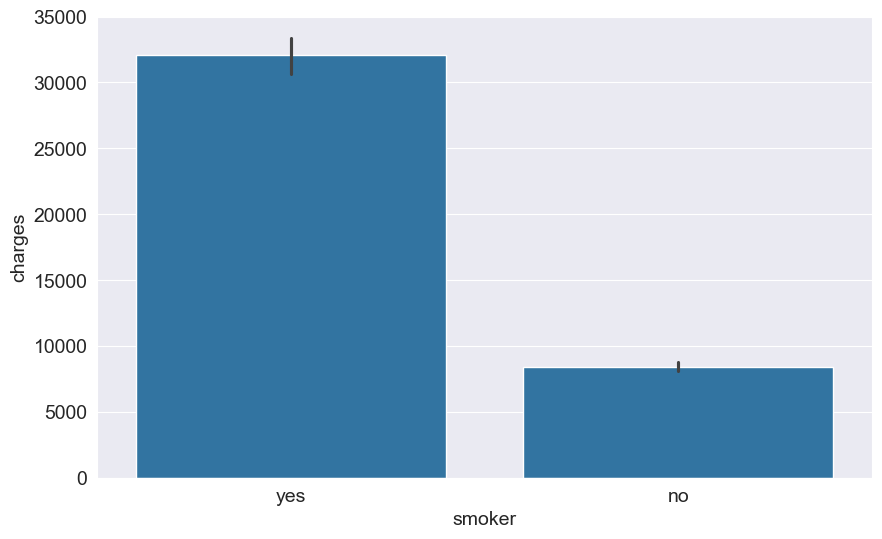

In [148]:
sns.barplot(data=df,x='smoker',y='charges');

In [149]:
smoker_code={'yes':1,'no':0}
df['smoker_code']=df.smoker.map(smoker_code)
df.head(10)

,age,sex,bmi,children,smoker,region,charges,smoker_code
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0
5,31,female,25.740,0,no,southeast,3756.62160,0
6,46,female,33.440,1,no,southeast,8240.58960,0
7,37,female,27.740,3,no,northwest,7281.50560,0
8,37,male,29.830,2,no,northeast,6406.41070,0
9,60,female,25.840,0,no,northwest,28923.13692,0


In [150]:
df.charges.corr(df.smoker_code)

0.7872514304984767

In [151]:
#Lets create a function for LinearRegression mmodel

def LinearRegression_method(inputs,targets):
    # Create and train the model
    model = LinearRegression().fit(inputs, targets)

# Generate predictions
    predictions = model.predict(inputs)

# Compute loss to evalute the model
    loss = rmse(targets, predictions)
    print('Loss:', loss)


    We can now use the smoker_code column for linear regression.
>charges=w1​×age+w2​×bmi+w3​×charges+w4​×smoker+b

In [153]:
# Create inputs and targets
inputs, targets = df[['age', 'bmi', 'children', 'smoker_code']], df['charges']

#lets call LinearRegression_method()
LinearRegression_method(inputs,targets)

Loss: 6056.439217188081


    The loss reduces from 11355 to 6056, almost by 50%! This is an important lesson: never ignore categorical data.

    Let's try adding the "sex" column as well.
>charges=w1​×age+w2​×bmi+w3​×charges+w4​×smoker+w5​×sex+b

<Axes: xlabel='sex', ylabel='charges'>

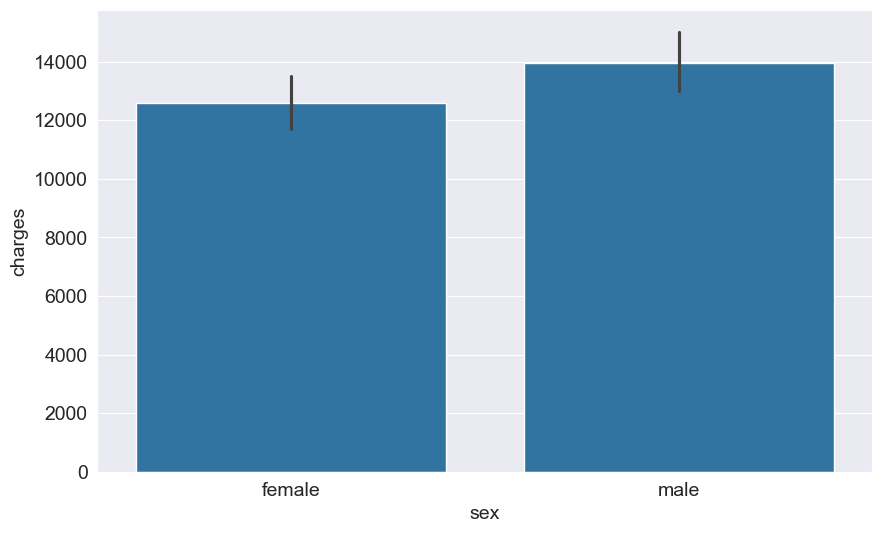

In [155]:
sns.barplot(data=df, x='sex', y='charges')

In [156]:
sex_code={'female':0,'male':1}
df['sex_code']=df.sex.map(sex_code)
df.head(10)

,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code
0,19,female,27.900,0,yes,southwest,16884.92400,1,0
1,18,male,33.770,1,no,southeast,1725.55230,0,1
2,28,male,33.000,3,no,southeast,4449.46200,0,1
3,33,male,22.705,0,no,northwest,21984.47061,0,1
4,32,male,28.880,0,no,northwest,3866.85520,0,1
5,31,female,25.740,0,no,southeast,3756.62160,0,0
6,46,female,33.440,1,no,southeast,8240.58960,0,0
7,37,female,27.740,3,no,northwest,7281.50560,0,0
8,37,male,29.830,2,no,northeast,6406.41070,0,1
9,60,female,25.840,0,no,northwest,28923.13692,0,0


In [157]:
df.charges.corr(df.sex_code)

0.057292062202025366

In [158]:
# Create inputs and targets
inputs,targets=df[['age','bmi','children','smoker_code','sex_code']],df['charges']

#lets call LinearRegression_method
LinearRegression_method(inputs,targets)

Loss: 6056.100708754546


    As you might expect, this doesn't have a significant impact on the loss. We can alos ignore sex column if we want

## One-hot Encoding
    The "region" column contains 4 values, so we'll need to use hot encoding and create a new column for each region.
<img src="One-hot Encoding.png" >

In [161]:
df.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

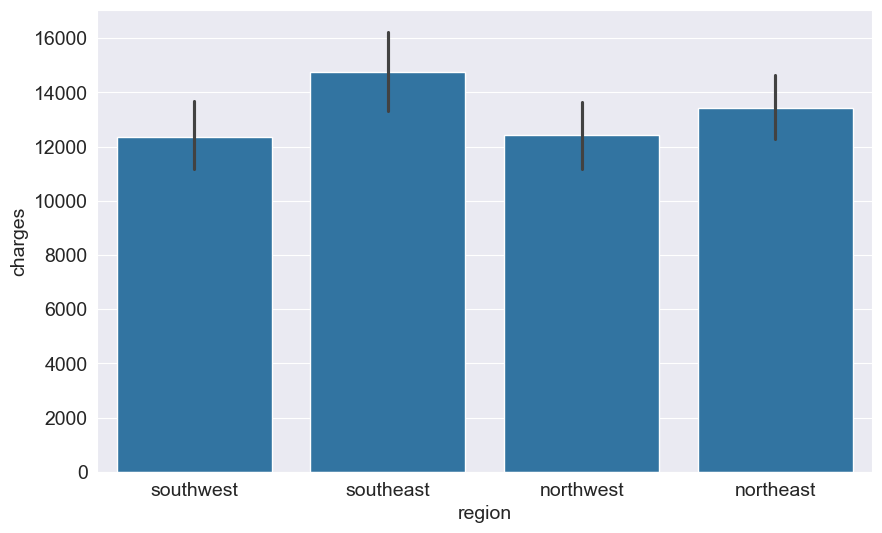

In [162]:
sns.barplot(data=df, x='region', y='charges');

In [163]:
from sklearn import preprocessing

# ✅ Step 1: Create the encoder object for one-hot encoding
enc=preprocessing.OneHotEncoder()

# ✅ Step 2: Fit the encoder on the 'region' column to learn the unique region values
enc.fit(df[["region"]])
enc.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [164]:
# ✅ Step 3: Transform the 'region' column into one-hot encoded array
# It returns a binary matrix (0s and 1s for each region)
one_hot=enc.transform(df[["region"]]).toarray()
one_hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [165]:
# ✅ Step 4: Assign the one-hot encoded matrix to new columns in the DataFrame
# Each column represents one region — 1 if the row belongs to that region, else 0
df[['northeast', 'northwest', 'southeast', 'southwest']]=one_hot
df
#one-hot encoding is a one-to-many transformation.
#For each value in 'region', you're creating multiple binary columns (like northeast, northwest, etc.). 
#That can’t be done with map()[map() is used for one-to-one transformations.] — it’s not built for multi-column expansions.


,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0.0,0.0,0.0,1.0


    Let's include the region columns into our linear regression model.
>charges=w1​×age+w2​×bmi+w3​×charges+w4​×smoker+w5​×sex+w6​×region1+w7​×region2+w8​×region3+w9​×region4+b

In [167]:
# Create inputs and targets
input_cols = ['age', 'bmi', 'children', 'smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs, targets = df[input_cols], df['charges']

#lets call LinearRegression_method
# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6041.6796511744515


    Once again, this leads to a fairly small reduction in the loss.  we can clearly see that lot of these other facetor are not helping. It seems like age and smoker were the two biggest factor and rest of them dont really matter

     We can see wo separate linear regression models, one for smokers and one of non-smokers, better than a single linear regression model

# Model Improvements
    Let's discuss and apply some more improvements to our model.

## Feature Scaling
    Recall that due to regulatory requirements, we also need to explain the rationale behind the predictions our model.

>charges=w1​×age+w2​×bmi+w3​×charges+w4​×smoker+w5​×sex+w6​×region+b

    To compare the importance of each feature in the model, our first instinct might be to compare their weights.

In [171]:
model.coef_,model.intercept_

(array([  256.85635254,   339.19345361,   475.50054515, 23848.53454191,
         -131.3143594 ,   587.00923503,   234.0453356 ,  -448.01281436,
         -373.04175627]),
 -12525.547811195444)

In [172]:
weights_df = pd.DataFrame({
    'feature': input_cols + ['bias'],          
    'weight': list(model.coef_) + [model.intercept_]
})
weights_df

,feature,weight
0,age,256.856353
1,bmi,339.193454
2,children,475.500545
3,smoker_code,23848.534542
4,sex_code,-131.314359
5,northeast,587.009235
6,northwest,234.045336
7,southeast,-448.012814
8,southwest,-373.041756
9,bias,-12525.547811


    While it seems like BMI and the "northeast" have a higher weight than age, keep in mind that the range of values for BMI is limited (15 to 40) and the "northeast" column only takes the values 0 and 1.

    Because different columns have different ranges, we run into two issues:

>We can't compare the weights of different column to identify which features are important

>A column with a larger range of inputs may disproportionately affect the loss and dominate the optimization process.

    For this reason, it's common practice to scale (or standardize) the values in numeric column by subtracting the mean and dividing by the standard deviation.
<img src="Scaling.png">

    We can apply scaling using the StandardScaler class from scikit-learn.

In [175]:
df

,age,sex,bmi,children,smoker,region,charges,smoker_code,sex_code,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1,0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0,1,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0,1,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,0,0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,0,0,0.0,0.0,0.0,1.0


In [298]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['age', 'bmi', 'children'] 
# scaler=StandardScaler()
# scaled_inputs=scaler.fit_transform(df[numeric_cols])
# scaled_inputs
scaler = StandardScaler()
scaler.fit(df[numeric_cols])
scaled_inputs = scaler.transform(df[numeric_cols])
scaled_inputs

array([[-1.43876426, -0.45332   , -0.90861367],
       [-1.50996545,  0.5096211 , -0.07876719],
       [-0.79795355,  0.38330685,  1.58092576],
       ...,
       [-1.50996545,  1.0148781 , -0.90861367],
       [-1.29636188, -0.79781341, -0.90861367],
       [ 1.55168573, -0.26138796, -0.90861367]])

In [177]:
scaler.mean_,scaler.var_

(array([39.20702541, 30.66339686,  1.09491779]),
 array([197.25385199,  37.16008997,   1.45212664]))

In [300]:

cat_cols = ['smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast']
categorical_data = df[cat_cols].values

    These can now we combined with the categorical data

In [302]:
inputs = np.concatenate((scaled_inputs, categorical_data), axis=1)
targets = df.charges

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6041.6796511744515


    We can now compare the weights in the formula:

In [308]:
#Alternate way

# ✅ Step 1: One-hot encode categorical 'region', drop one to avoid multicollinearity
df_encoded = pd.get_dummies(df, columns=['region'], drop_first=False)

# ✅ Step 2: Define numeric and categorical columns
numeric_cols = ['age', 'bmi', 'children']
cat_cols = ['smoker_code', 'sex_code', 'region_northwest', 'region_southeast', 'region_southwest','region_southwest']
# 'region_northeast' is dropped and acts as the reference

# ✅ Step 3: Standardize numeric columns
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df_encoded[numeric_cols])

# ✅ Step 4: Combine inputs
categorical_data = df_encoded[cat_cols].values
inputs = np.concatenate((scaled_numeric, categorical_data), axis=1)
targets = df_encoded['charges']

# ✅ Step 5: Train model
model = LinearRegression().fit(inputs, targets)

# ✅ Step 6: Evaluate with RMSE
predictions = model.predict(inputs)

loss = rmse(targets, predictions)
print('Loss (RMSE):', loss)

# ✅ Step 7: Show weights
all_features = numeric_cols + cat_cols
weights_df = pd.DataFrame({
    'feature': np.append(all_features, 'bias'),
    'weight': np.append(model.coef_, model.intercept_)
})
print(weights_df.sort_values('weight', ascending=False))

Loss (RMSE): 6041.795350228959
            feature        weight
8  region_southwest  5.778763e+16
3       smoker_code  2.384485e+04
9              bias  9.102422e+03
0               age  3.607849e+03
1               bmi  2.073943e+03
2          children  5.668100e+02
4          sex_code -1.325247e+02
5  region_northwest -3.957252e+02
6  region_southeast -1.086589e+03
7  region_southwest -5.778763e+16


In [183]:
weights_df = pd.DataFrame({
    'feature': np.append(numeric_cols + cat_cols, 1),
    'weight': np.append(model.coef_, model.intercept_)
})
weights_df.sort_values('weight', ascending=True)

,feature,weight
7,region_southwest,-5.778763e+16
6,region_southeast,-1.086589e+03
5,region_northwest,-3.957252e+02
4,sex_code,-1.325247e+02
2,children,5.668100e+02
1,bmi,2.073943e+03
0,age,3.607849e+03
9,1,9.102422e+03
3,smoker_code,2.384485e+04
8,region_southwest,5.778763e+16


    As you can see now, the most important feature are:

>1. Smoker
 
>2. Age

>3. BMI

In [185]:
model.predict([[23, 24, 0, 0, 1, 0, 1, 0,0]])  # Row: Age 23, BMI 24, Children 0, Smoker 0, Male, Region Southeast

array([140638.47676464])

    whenever we are calulating for new customer we need to scale them before we put them into the model

In [187]:
 

new=[[28, 30, 2, 1, 0, 0, 1,0,0]]
scaler.transform([[28, 30, 2]])


C:\Users\amrit\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



array([[-0.79795355, -0.10882659,  0.75107928]])

In [188]:
model.predict([[-0.79795355, -0.10882659,  0.75107928, 1, 0, 0, 1,0,0]])

array([29181.80232802])

# Creating a Test Set
    Models like the one we've created in this tutorial are designed to be used in the real world. It's common practice to set aside a small fraction of the data (e.g. 10%) just for testing and reporting the results of the model.

In [310]:
from sklearn.model_selection import train_test_split

inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.1)

# Create and train the model
model = LinearRegression().fit(inputs_train, targets_train)

# Generate predictions
predictions_test = model.predict(inputs_test)

# Compute loss to evalute the model
loss = rmse(targets_test, predictions_test)
print('Test Loss:', loss)

Test Loss: 5910.180368929703


In [312]:
# Generate predictions
predictions_train = model.predict(inputs_train)

# Compute loss to evalute the model
loss = rmse(targets_train, predictions_train)
print('Training Loss:', loss)

Training Loss: 6056.920744347413




    Now it looks like what we typically expect:

🔹 Training Loss (6028) is slightly lower than
🔹 Test Loss (6190)

    This suggests that:

>Your model is learning well from the training data ✅

>It’s also generalizing nicely to unseen data ✅

>And there’s no overfitting or underfitting going on 

    You’re studying for a test.

    You practice with 90 questions.
    Then, the teacher gives you 10 new unseen questions in the actual exam.
    If you do well on those 10, it means you understood the concept — not just memorized answers.

    In ML, the 90% is for practice (training), and the 10% is the test — to see how well the model performs on unseen data.

    🧠 Why not just use 100% data for training?
    Because if you do that:

    The model has nothing left to prove its skills on.
    You won’t know if it’s just memorizing the answers or actually learning patterns.
    It could perform great on training data but fail badly on new data (this is called overfitting).

    🧪 So here’s what 90-10 is doing:

    Purpose	Data Used	What Happens
    Training	90%	The model learns from this data (features + correct answers)
    Testing	10%	The model is challenged with new data to prove it learned something real
    🔄 Can we use different splits?
    Yes! Common ones are:

    80-20 (for more reliable testing)

    70-30 (more aggressive testing)

    90-10 (when data is limited and you want to train well)

    👉 You can even use cross-validation, which is like shuffling and splitting multiple times to ensure fairness.